# ROBOTICS - Tutorial 1 : Direct and inverse kinematics



## Introduction

We propose to study the __geometric__ and __kinematic__ modeling of a manipulator arm developed by the *Interactive Robotics Laboratory* of the *CEA List*. This robot, which kinematic chain is of serial type, has $6$ revolute joints ($j_i$ with $i=1,\ldots,6$).


<img src="Images/VueRobot.png" width="400">


The numerical values of the robot parameters, required for the completion of this tutorial, are specified in the following table.

$$
\begin{aligned}
& \text {Table. Numerical values of the robot parameters.}\\
&\begin{array}{cccc}
\hline
		\text{Parameters} &	\text{Numerical values} &	\text{Type of parameter} \\ 
		\hline
		d_3 & 0.7 m & \text{Geometric parameter} \\
		r_1 & 0.5 m & \text{Geometric parameter} \\
		r_4 & 0.2 m & \text{Geometric parameter} \\
        r_E & 0.1 m & \text{Geometric parameter} \\
\hline
\end{array}
\end{aligned}
$$

The use of *Python* is required to perform the tutorial. Please import the following required mathematical libraires to start the tutorial.

In [1]:
import numpy as np
import math as m
import functools as fu
from numpy.linalg import eig
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

%matplotlib inline

In the following, you will progressively update a *Dictionnary* in Python containing the robot parameters, named __robotParameters__.

Please initialize it as follows: 
*robotParameters = { 'nJoints': 6, 'jointsType': ['R','R','R','R','R','R']}*

In [2]:
robotParameters = { 'nJoints': 6, 'jointsType': ['R','R','R','R','R','R']}

You will also progressively build a *Class* containing some *attributes* related to the robot. To do so, you will be asked to program some of its *methods* in the tutorial. This class is named __RobotModel__ and is defined in the file *ClassRobotModel*.

Please initialize it as follows. You will see printing the resulting *attributes* of the *Class* __RobotModel__.

In [3]:
from ClassRobotModel import RobotModel
RobotTutorials = RobotModel( **robotParameters )

Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]


## Direct geometric model

__Q1.__ *Modified Denavit-Hartenberg (MDH)* parameters defining the spatial arrangement of the robot structure.

<img src="Images/question1.png" width="600">

__Q2.__ Geometric parameters of the robot:

$$
\begin{array}{ccccc}
		\hline
		\hline
		 i  & \alpha_i & d_i & \theta_i & r_i \\
		\hline
		\hline
		1  & 0 & 0 & 0 & 0.5 \\
		\hline
		2  & pi/2 & 0 & 0 & 0 \\
		\hline
		3  & 0 & 0.7 & pi/2 & 0 \\
		\hline
		4  & pi/2 & 0 & 0 & 0.2 \\
		\hline
		5  & -pi/2 & 0 & 0 & 0 \\
		\hline
		6  & pi/2 & 0 & 0 & 0 \\
		\hline
		\hline
\end{array}
$$

also in *DHM_parameters.txt*

In [4]:
robotParameters['fileDHM'] = "DHM_parameters.txt"
RobotTutorials = RobotModel( **robotParameters )

Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]


__Q3-a.__ Write a generic function $TransformMatElem(\alpha_i, d_i, \theta_i, r_i)$ which output argument is the homogeneous transform matrix *g* between two successive frames.

In [5]:
@staticmethod
def TransformMatElem(alpha_i, d_i, theta_i, r_i):
    """ 
    Computation of the homogeneous transform matrix between two successive frames R_(i-1) and R_i
    
    Input: 
        - Four scalar parameters given by the Modified Denavit-Hartenberg (MDH) convention
         
    Output: 
        - Homogeneous transform matrix g_(i-1,i) as a "np.array"
    """
    
    ca = np.cos(alpha_i)
    sa = np.sin(alpha_i)
    ct = np.cos(theta_i)
    st = np.sin(theta_i)
    
    return np.array([
        [ct,      -st,     0,      d_i],
        [st*ca,   ct*ca,   -sa,    -sa*r_i],
        [st*sa,   ct*sa,   ca,     ca*r_i],
        [0,       0,       0,      1]
    ])

RobotModel.TransformMatElem = TransformMatElem

__Q3-b.__Write a function $ComputeDGM(\text{self}, q)$ which computes the direct geometric model of any robot with series open kinematic chain, taking as input arguments the current configuration.

In [6]:
def ComputeDGM(self, q_cur):
    """
    Computation of the Direct Geometric Model (DGM) of the robot given by its MDH parameters for the joint configuration q_cur
        
    Inputs: 
        - List of robot's geometric parameters "self.tableDHM" given by the Modified Denavit-Hartenberg (MDH) convention
        - Number of joints of the robot "self.numberJoints"
        - List of type of joints of the robot: "self.sigma"
        - Current joint configuration "q_cur"
        
    Outputs: 
        - List of the successive homogeneous transform matrices: "self.list_g_i_1_i = [g_01, ..., g_N_1_N]"
        - List of the successive resulting homogeneous transform matrices: "self.list_g_0i = [g_01, g_02, ..., g_ON]"
    """
       
    self.list_g_i_1_i = []
    
    for i, alpha, d, theta, r in self.tableDHM:
        idx = int(i) - 1
        if self.sigma[idx] == 0:
            d_i = d
            theta_i = theta + q_cur[idx]
        else:
            d_i = d + q_cur[idx]
            theta_i = theta
        
        self.list_g_i_1_i.append(self.TransformMatElem(alpha, d_i, theta_i, r))
    
    self.list_g_0i = [self.list_g_i_1_i[0]]
    for g_i_1_i in self.list_g_i_1_i[1:]:
        self.list_g_0i.append(self.list_g_0i[-1] @ g_i_1_i)
    
    return self.list_g_i_1_i, self.list_g_0i
            
RobotModel.ComputeDGM = ComputeDGM

__Q3-c.__ We consider an end-effector mounted at the end of the robot arm. The frame $\mathcal{R}_E$ attached to the end-effector of the robot is defined by a translation of the frame  $\mathcal{R}_6$ by a distance $r_E$ along the $z_6$ axis.

Specify the four DHM parameters for the tool frame description in the field below.


In [7]:
robotParameters['toolFrameDHM'] = [0, 0, 0, 0.1]
RobotTutorials = RobotModel( **robotParameters )

Attribute (int): self.numberJoints =  6
Attribute (list): self.jointsType =  ['R', 'R', 'R', 'R', 'R', 'R']
Attribute (list - 0 if self.jointsType[i] == 'R' / 1 if self.jointsType[i] == 'P'): self.sigma =  [0, 0, 0, 0, 0, 0]
Attribute (list - float): self.tableDHM =  [[1.0, 0.0, 0.0, 0.0, 0.5], [2.0, 1.5707963267948966, 0.0, 0.0, 0.0], [3.0, 0.0, 0.7, 1.5707963267948966, 0.0], [4.0, 1.5707963267948966, 0.0, 0.0, 0.2], [5.0, -1.5707963267948966, 0.0, 0.0, 0.0], [6.0, 1.5707963267948966, 0.0, 0.0, 0.0]]
Attribute (list - float): self.toolDHM =  [0, 0, 0, 0.1]


Using the results of previous questions, write a function $ComputeToolPose(\text{self})$  that computes the homogeneous transform matrix $\overline{g}_{0E}$. This matrix gives the position and the orientation of the frame $\mathcal{R}_E$ attached to the end-effector of the robot, expressed in the base frame $\mathcal{R}_0$.

In [8]:
def ComputeToolPose(self):
   """ 
   Computation of the homogeneous transform matrix g0E which gives the position and the orientation of the frame R_E attached to the end-effector of the robot, expressed in the base frame R_0 evaluated at the joint configuration q_cur
   
   Inputs: 
      - List of the successive homogeneous transform matrices "self.list_g_0i"
      - Number of joints of the robot "self.numberJoints"
      - List of the geometric parameters of the tool "self.toolDHM" given by the Modified Denavit-Hartenberg (MDH) convention
      
   Output: 
      - Homogeneous transform matrix "self.g_0E"
   """
   
   alpha, d, theta, r = self.toolDHM
   self.g_0E = self.list_g_0i[-1] @ self.TransformMatElem(alpha, d, theta, r)
   
   return self.g_0E
            
RobotModel.ComputeToolPose = ComputeToolPose

In the following, we consider two joint configurations $q=\left[q_1, \ldots, q_6\right]^t$ of the robot: $q_i=\left[-\frac{\pi}{2}, 0 , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} \right]^t$ and $q_f=\left[0, \frac{\pi}{4}  , 0 , \frac{\pi}{2} , \frac{\pi}{2} , 0\right]^t$.

Indicate what are the homogeneous transform matrices $\overline{g}_{0E}$ evaluated in these two confugrations.

In [24]:
q_i = [-np.pi/2,
       0,
       -np.pi/2,
       -np.pi/2,
       -np.pi/2,
       -np.pi/2]

q_f = [0,
       np.pi/4,
       0,
       np.pi/2,
       np.pi/2,
       0]

RobotTutorials.ComputeDGM(q_i)
print(f'g_0E(q_i) = \n{RobotTutorials.ComputeToolPose()}')

RobotTutorials.ComputeDGM(q_f)
print(f'g_0E(q_f) = \n{RobotTutorials.ComputeToolPose()}')

g_0E(q_i) = 
[[-6.12323400e-17 -6.12323400e-17 -1.00000000e+00 -1.00000000e-01]
 [ 1.00000000e+00 -1.23259516e-32 -6.12323400e-17 -7.00000000e-01]
 [-1.23259516e-32 -1.00000000e+00  6.12323400e-17  3.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
g_0E(q_f) = 
[[-7.07106781e-01  7.07106781e-01  3.01573569e-33  6.36396103e-01]
 [-4.32978028e-17 -4.32978028e-17 -1.00000000e+00 -1.00000000e-01]
 [-7.07106781e-01 -7.07106781e-01  6.12323400e-17  1.13639610e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


__Q4.__ What are the values of positions $P_x, P_y, P_z$ and the parameters related to the orientation $R_{n,q}$ ($n$ being the direction vector and $q \in \left[0,\pi\right]$ the rotation angle such that $R_{n,q}=R_{0E}$) of the end-effector frame for the two joint configurations $q_i=\left[-\frac{\pi}{2}, 0 , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} , -\frac{\pi}{2} \right]^t$ and $q_f=\left[0, \frac{\pi}{4}  , 0 , \frac{\pi}{2} , \frac{\pi}{2} , 0\right]^t$ ($q=\left[q_1, \ldots, q_6\right]^t$)?
To do so, write a function $DescribeToolFrame(\text{self})$ that computes the position vector and the parameters related to the orientation of the end-effector frame for the current configuration.

In [10]:
def DescribeToolFrame(self):
        """ 
        Computation of the position vector and the parameters related to the orientation R_n,q of the end-effector frame for the configuration q as specified in the constructor function 
                  
        Input: 
           - Direct Geometric Model (DGM) of the robot including its end-effector through "self.g_0E"
         
        Outputs: 
           - Values of positions P=[Px, Py, Pz]' (in m) of the origin of frame R_E w.r.t. R_0 given in R_0: "self.P"
           - Orientation parameters R_n,q, as follows:
                   - "self.n": being the direction vector
                   - "self.q" in [0,pi] the rotation angle in rad such that R_n,q = R_0E
        """
        
        g_0E = self.g_0E
        self.P = g_0E[0:3, 3]
        self.n = g_0E[0:3, 0]
        self.q = np.arccos((np.trace(g_0E[0:3,0:3]) - 1)/2)
        
        return self.P, self.n, self.q
        
RobotModel.DescribeToolFrame = DescribeToolFrame  

## Direct kinematic model

__Q5.__ Write a function $ComputeJac\left(self, q\right)$ which output is the Jacobian matrix ${}^0J(q)$ (computed by the method of velocities composition).

Reminder: the Jacobian matrix relates the velocities in the task coordinates of the end-effector frame in $\mathcal{R}_0$, for a given joint configuration $q$, to the joint velocities:
\begin{align*}
{}^0\mathcal{V}_{0,E}&= \begin{bmatrix}^0V_{0,E}\left(O_E\right) \\ ^0\omega_{0,E} \end{bmatrix} = \begin{bmatrix} {}^0J_v \left(q\right)  \\ {}^0J_{\omega} \left(q\right)\end{bmatrix} \dot{q} = {}^0J\left(q\right) \dot{q}
\end{align*}

In [13]:
def ComputeJac(self, q_cur):
    """
    Computation of the Jacobian matrix mapping the joint velocities to the velocities of the end-effector for a joint configuration "q_cur"

    Inputs:
        - List defining the types of joints : "self.jointsType"
        - Number of joints of the robot: "self.numberJoints"
        - Current configuration "q_cur"

    Output:
        - Jacobian matrix 0_J in R_0: "self.oJ" as np.array
    """
        
    self.ComputeDGM(q_cur)
    

    self.oJ = np.zeros((6, self.numberJoints))

    O_E = self.ComputeToolPose()[0:3, 3]

    for i in range(self.numberJoints):
        if i == 0:
            z_i_1 = np.array([0, 0, 1])
            O_i_1 = np.array([0, 0, 0])
        else:
            z_i_1 = self.list_g_0i[i-1][0:3, 2]
            O_i_1 = self.list_g_0i[i-1][0:3, 3]

        if self.sigma[i] == 0:
            self.oJ[0:3, i] = np.cross(z_i_1, O_E - O_i_1)
            self.oJ[3:6, i] = z_i_1
        else:
            self.oJ[0:3, i] = z_i_1
            self.oJ[3:6, i] = np.array([0, 0, 0])
        
    return self.oJ
    
RobotModel.ComputeJac = ComputeJac

What are the values of the twists at $O_E$ evaluated with $q=q_i$ and $q=q_f$ with the joint velocities $\dot q = \left[0.5, 1.0, -0.5, 0.5, 1.0, -0.5\right]^t$?

In [27]:
def compute_and_print_twist(robot, q, q_dot, config_name):
    twist = robot.ComputeJac(q) @ q_dot        
    print(f"\nTwist at O_E for {config_name}")
    print(f"V_0E = [{twist[0]:.4f}, {twist[1]:.4f}, {twist[2]:.4f}]^T m/s | omega_0E = [{twist[3]:.4f}, {twist[4]:.4f}, {twist[5]:.4f}]^T rad/s")
    return twist

q_dot = np.array([0.5, 1.0, -0.5, 0.5, 1.0, -0.5])
q_dot_str = ', '.join([f'{v:.1f}' for v in q_dot])

print(f"Using q_dot = [{q_dot_str}]^T:")

twist_qi = compute_and_print_twist(RobotTutorials, q_i, q_dot, "Qi")
twist_qf = compute_and_print_twist(RobotTutorials, q_f, q_dot, "Qf")

#print(twist_qi)
#print(twist_qf)

Using q_dot = [0.5, 1.0, -0.5, 0.5, 1.0, -0.5]^T:

Twist at O_E for Qi
V_0E = [1.0500, -0.0500, -0.3000]^T m/s | omega_0E = [-0.0000, 0.5000, 0.5000]^T rad/s

Twist at O_E for Qf
V_0E = [0.5036, 0.9546, -0.2828]^T m/s | omega_0E = [0.3536, 0.0000, 2.5607]^T rad/s


__Q6.__ In the rest of the study, we restrict the analysis of operational end-effector velocities to translational velocities via ${}^0J_v \left(q\right)$.

Qualify the transmission of velocities between the joint and task spaces for the corresponding $q_i$ and $q_f$ configurations: 

- what is the preferred direction to transmit velocity in the task space when the manipulator configuration is $q_i$? Same question for $q_f$? 
- What are the corresponding velocity manipulabilities? 

To help, you can program a function $QualifyVelocityTransmission(self)$ that analyses the property of the Jacobian matrix. Explain your results.

In [34]:
def QualifyVelocityTransmission(self, q_cur):
    """
    Qualifying the transmission of velocities

    Input:
       - Jacobian matrix "self.oJ" to be analysed
       - Configuration q_to_analyse to compute the Jacobian at
    """

    J_v = self.ComputeJac(q_cur)[0:3, :]

    U, Sigma, Vt = np.linalg.svd(J_v)
    V = Vt.T

    sigma_max = Sigma[0]      # Maximum singular value
    sigma_min = Sigma[-1]     # Minimum singular value
    u_max = U[:, 0]           # Best direction (task space)
    u_min = U[:, -1]          # Worst direction (task space)

    W = np.prod(Sigma)  # Velocity manipulability measure

    # Singularity analysis
    singularity_threshold = 1e-4  # Threshold for singularity detection
    is_singular = W < singularity_threshold
    
    q_to_analyse_str = '[' + ', '.join([f'{v:.1f}' for v in q_cur]) + ']'
    print(f"=== Velocity Transmission Analysis @ {q_to_analyse_str} ===\n")
    print(f"Singular values: {Sigma}")
    print(f"Velocity manipulability (w): {W:.6f}")
    
    if is_singular:
        print("Configuration is near singularity!")
        print(f"Manipulability w = {W:.2e} < threshold = {singularity_threshold:.2e}")
    else:
        print(f"Configuration is well-conditioned (w > {singularity_threshold:.2e})\n")
    
    print("Principal directions in task space (columns of U):")
    for i in range(3):
        print(f"  Direction u{i+1}: [{U[0,i]:7.4f}, {U[1,i]:7.4f}, {U[2,i]:7.4f}]^T (sigma{i+1} = {Sigma[i]:.4f})")

    print(f"\nBest transmission direction: [{u_max[0]:7.4f}, {u_max[1]:7.4f}, {u_max[2]:7.4f}]^T")
    print(f"Worst transmission direction: [{u_min[0]:7.4f}, {u_min[1]:7.4f}, {u_min[2]:7.4f}]^T")

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    u_sphere = np.linspace(0, 2 * np.pi, 50)
    v_sphere = np.linspace(0, np.pi, 50)
    x_sphere = np.outer(np.cos(u_sphere), np.sin(v_sphere))
    y_sphere = np.outer(np.sin(u_sphere), np.sin(v_sphere))
    z_sphere = np.outer(np.ones(np.size(u_sphere)), np.cos(v_sphere))

    ellipsoid_points = []
    for i in range(len(u_sphere)):
        for j in range(len(v_sphere)):
            sphere_pt = np.array([x_sphere[i,j], y_sphere[i,j], z_sphere[i,j]])
            ellipsoid_pt = U @ np.diag(Sigma) @ sphere_pt
            ellipsoid_points.append(ellipsoid_pt)

    ellipsoid_points = np.array(ellipsoid_points)
    x_ellipsoid = ellipsoid_points[:, 0].reshape(len(u_sphere), len(v_sphere))
    y_ellipsoid = ellipsoid_points[:, 1].reshape(len(u_sphere), len(v_sphere))
    z_ellipsoid = ellipsoid_points[:, 2].reshape(len(u_sphere), len(v_sphere))

    P_E = self.g_0E[0:3, 3]

    ax.plot_surface(x_ellipsoid + P_E[0], y_ellipsoid + P_E[1], z_ellipsoid + P_E[2],
                    alpha=0.3, color='cyan', edgecolor='none')

    colors = ['red', 'green', 'blue']
    labels = ['Max', 'Mid', 'Min']
    for i in range(3):
        direction = U[:, i] * Sigma[i]
        ax.quiver(P_E[0], P_E[1], P_E[2],
                 direction[0], direction[1], direction[2],
                 color=colors[i], arrow_length_ratio=0.15, linewidth=2.5,
                 label=f'{labels[i]} (sigma={Sigma[i]:.3f})')

    ax.scatter([P_E[0]], [P_E[1]], [P_E[2]], color='black', s=100,
              label='End-effector', marker='o')

    ax.set_xlabel('X [m]', fontsize=10)
    ax.set_ylabel('Y [m]', fontsize=10)
    ax.set_zlabel('Z [m]', fontsize=10)
    
    title = 'Velocity Manipulability Ellipsoid\n' + f'Manipulability w = {W:.4f} \nq={q_to_analyse_str}'
    if is_singular:
        title += ' SINGULARITY'
    
    ax.set_title(title, fontsize=12, fontweight='bold')

    max_range = np.array([x_ellipsoid.max()-x_ellipsoid.min(),
                          y_ellipsoid.max()-y_ellipsoid.min(),
                          z_ellipsoid.max()-z_ellipsoid.min()]).max() / 2.0

    mid_x = (x_ellipsoid.max()+x_ellipsoid.min()) * 0.5 + P_E[0]
    mid_y = (y_ellipsoid.max()+y_ellipsoid.min()) * 0.5 + P_E[1]
    mid_z = (z_ellipsoid.max()+z_ellipsoid.min()) * 0.5 + P_E[2]

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

RobotModel.QualifyVelocityTransmission = QualifyVelocityTransmission

To answear the previous question we run the QualifyVelocityTransmission function for each joint:

=== Velocity Transmission Analysis @ [-1.6, 0.0, -1.6, -1.6, -1.6, -1.6] ===

Singular values: [1.00147457 0.73565549 0.21414872]
Velocity manipulability (w): 0.157772
Configuration is well-conditioned (w > 1.00e-04)

Principal directions in task space (columns of U):
  Direction u1: [-0.9858,  0.1616, -0.0450]^T (sigma1 = 1.0015)
  Direction u2: [-0.0897, -0.2811,  0.9555]^T (sigma2 = 0.7357)
  Direction u3: [ 0.1418,  0.9460,  0.2916]^T (sigma3 = 0.2141)

Best transmission direction: [-0.9858,  0.1616, -0.0450]^T
Worst transmission direction: [ 0.1418,  0.9460,  0.2916]^T


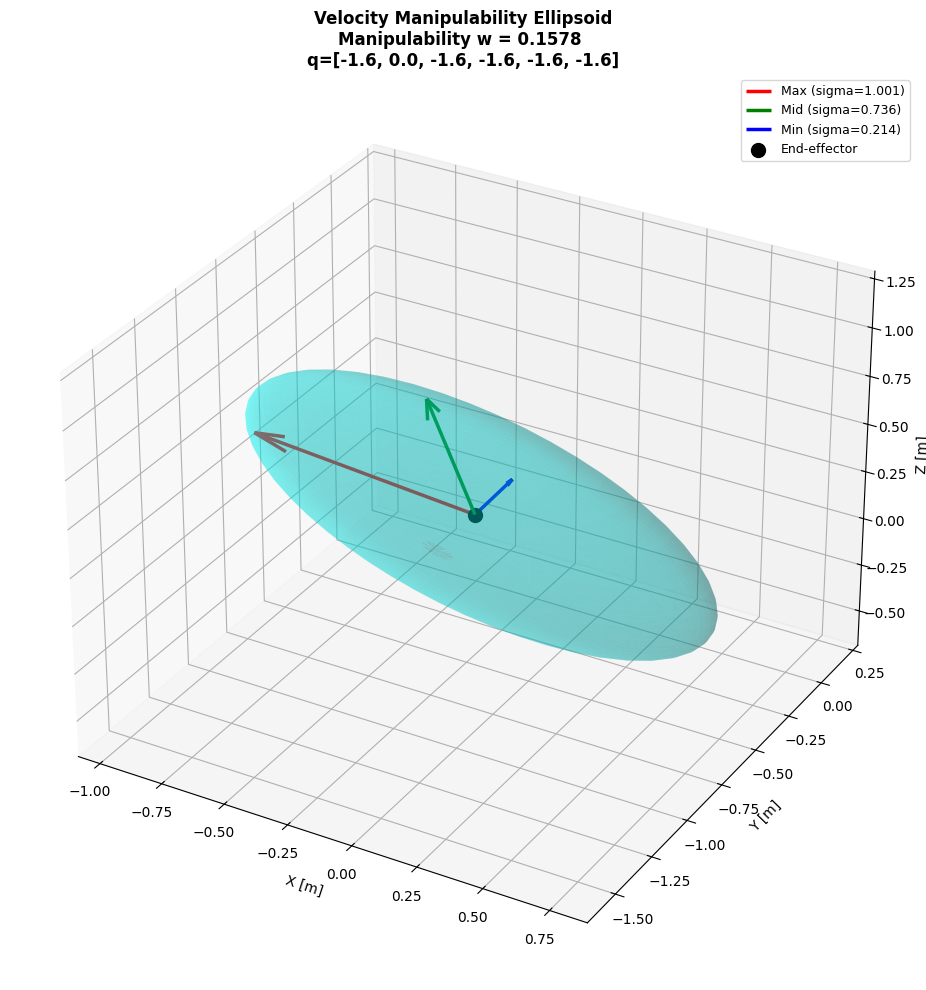

In [ ]:
RobotTutorials.QualifyVelocityTransmission(q_i)

=== Velocity Transmission Analysis @ [0.0, 0.8, 0.0, 1.6, 1.6, 0.0] ===

Singular values: [0.96901327 0.86668145 0.0993808 ]
Velocity manipulability (w): 0.083463
Configuration is well-conditioned (w > 1.00e-04)

Principal directions in task space (columns of U):
  Direction u1: [-0.6103, -0.6022,  0.5147]^T (sigma1 = 0.9690)
  Direction u2: [ 0.3656, -0.7905, -0.4915]^T (sigma2 = 0.8667)
  Direction u3: [ 0.7028, -0.1118,  0.7026]^T (sigma3 = 0.0994)

Best transmission direction: [-0.6103, -0.6022,  0.5147]^T
Worst transmission direction: [ 0.7028, -0.1118,  0.7026]^T


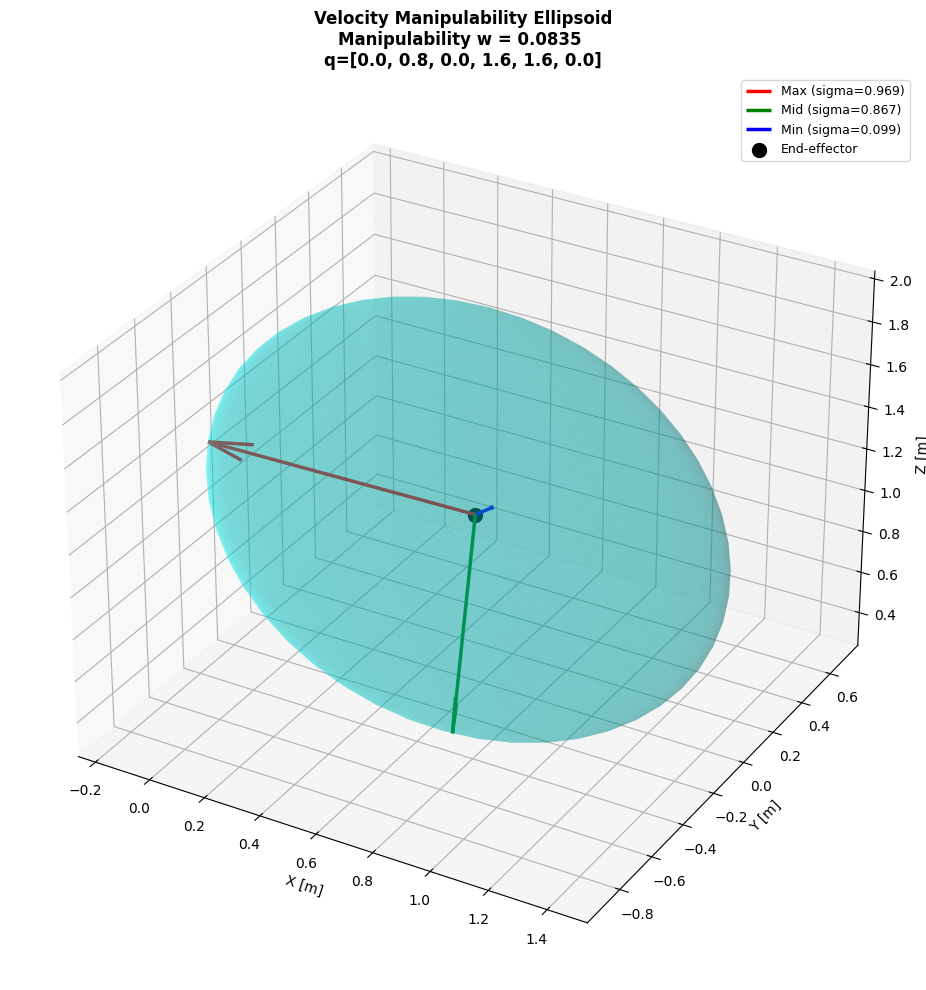

In [36]:
RobotTutorials.QualifyVelocityTransmission(q_f)

## Inverse geometric model

__Q7.__ In this study, the resolution of the inverse geometric model is considered numerically by exploiting the inverse differential model. Moreover, the study is restricted to the position only of the robot's end-effector frame in the task space (no constraint on the orientation of the end-effector frame).

Using an iterative procedure exploiting the pseudo-inverse of the Jacobian matrix, program a function $ComputeIGM(\text{self}, X_d, q_0, k_{max}, \epsilon_x)$ having as input arguments the desired task position $X_d$ and the initial condition $q_0$. Both the maximum number of iterations $k_{max}$ of the algorithm and the norm of the tolerated Cartesian error $|X_d - DGM(q_{k})|<\epsilon_x$, define the stopping criteria of the algorithm.

In [17]:
def ComputeIGM(self, X_d, q_0, k_max, eps_x):    
        """ 
        Computation of the Inverse Geometric Model (IGM) mapping the Cartesian pose to the joint vector "q"
                
        Inputs: 
           - Desired Cartesian vector "X_d" as a np.array to be reached by the robot 
           - Initial condition "q_0" as a np.array
           - Number "k_max" of maximal iteration in the recursive algorithm 
           - Norm of the tolerated Cartesian error "eps_x"
         
        Outputs: 
           - List "self.list_q_IGM" of the joint vectors computed at each iteration of the recursive algorithm 
           - Returned "self.list_q_IGM[-1]" of the final found joint vector, solution of the IGM
           
        """
        
        # To be completed...
        # x=1
        return x

RobotModel.ComputeIGM = ComputeIGM 

Compute $q^{\ast}$ when the function is called with the following arguments:

a) $X_d=X_{d_i}=\left(-0.1, -0.7, 0.3\right)^t$, $q_0=\left[ -1.57, 0.00 , -1.47, -1.47, -1.47 , -1.47 \right.$ $\left., -1.47 \right]$, $k_{max}=100$, $\epsilon_x=1$mm?

b) $X_d=X_{d_f}=\left(0.64 , -0.10, 1.14\right)^t$, $q_0=\left[ 0 , 0.80 , 0.00 , 1.00 , 2.00 , 0.00 \right]$, $k_{max}=100$, $\epsilon_x=1$mm?

Check the accuracy of the results using the function calculated in __Q3.__

## Inverse kinematic model

In this question, the trajectory of the end-effector to be followed in the task space must allow the desired final position $X_{d_f}$ to be reached by following a straight line in the task space starting at the initial position $X_{d_i}$. This rectilinear motion is carried out at a constant speed $V=1m.s^{-1}$ and is sampled at a period $T_e=1$ms. The position of the end effector at the time instant $kT_e$ is noted $X_{d_k}$. The initial configuration of the robot is given by $q_i$ (found in question __Q4.__).

__Q8.__ Using the inverse differential kinematic model, write a function entitled $ComputeIKM( \text{self}, X_{d_i}, X_{d_f}, V, T_e, q_i)$ realizing the coordinate transform to provide the series of setpoint values $q_{d_k}$ corresponding to the $X_{d_k}$ to the joint drivers. To do this, after having programmed the time law corresponding to the required motion, you can use the function developed in question __Q7__ capable of calculating the iterative MGI from the pseudo-inverse of the Jacobian matrix.

In [18]:
def ComputeIKM(self, X_d_i, X_d_f, V, Te, q_i, k_max, eps_x):    
        """ 
        Computation of the Inverse differential Kinematic Model (IKM) making the coordinate transform to provide the series of setpoint values qdk corresponding to the Xdk to the joint drivers
        
        Inputs: 
           - Trajectory of the end effector to be followed in the task space between:
               - the initial position "X_d_i"
               - the desired final position "X_d_f" to be reached.
           - Rectilinear motion carried out :
               - at a constant speed "V"
               - sampled at a period "Te"
           - Initial configuration of the robot "q_i"
           - Number "k_max" of maximal iteration in the recursive algorithm (to be used with "self.ComputeIGM")
           - Norm of the tolerated Cartesian error "eps_x" (to be used with "self.ComputeIGM")
           
        Outputs: 
           - List "self.discreteTime" that defines the the sampled temporal series for each time step
           - List "self.list_X_d_k" of the intermediate Cartesian poses to be reached by the robot
           - List "self.list_q_dk" of the joint vectors computed at each iteration k of the recursive algorithm (series of setpoint values qdk corresponding to the Xdk to the joint drivers)
        """     
        
        # To be completed...

RobotModel.ComputeIKM = ComputeIKM 

Check that the successively reached positions of the end-effector is following the desired trajectory. To do so, you can plot the error between the sequence of positions reached by the end device and the position set points at each time step.

__Q9.__ Plot the temporal evolution of the joint variables $q_1$ to $q_6$ calculated in the previous question. For each joint variable, graphically overlay the allowable extreme values corresponding to the joint limits:
\begin{align*}
q_{min} = \left[\begin{array}{c}{ -\pi , -\frac{\pi}{2} , -\pi , -\pi , -\frac{\pi}{2}, -\pi }\end{array}\right] 
\end{align*}
and
\begin{align*}
q_{max} = \left[\begin{array}{c}{ 0 , \frac{\pi}{2} , 0  ,\frac{\pi}{2}, \frac{\pi}{2} , \frac{\pi}{2} }\end{array}\right] 
\end{align*}

Comment on the evolution of the joint variables obtained previously.

__Q10.__ In this question, we modify the algorithm developed in question __Q8__. We wish to take into account the distance of the values taken by the joint variables from their limits in the computation of the inverse kinematic model.

To do so, you will need to consider a secondary task aiming at keeping some distance from the articular stops $q_{min}$ and $q_{max}$. By the technique of the gradient projected into the null space of ${}^0J_v \left(q\right)$, you will consider minimizing the following potential function:
\begin{align*}
			H_{lim}\left(q\right) = \sum_{i=1}^{n} \left(\frac{q_i-\overline{q}_{i}}{q_{max}-q_{min}}\right)^2 \hspace{0.2cm} \text{where} \hspace{0.2cm} \overline{q}_{i} =  \frac{q_{max}+q_{min}}{2} 
\end{align*}

First, provide below the theoretical analytical solution for the joint variables to this problem.

Then, develop a new function $ComputeIKMlimits(\text{self}, X_{d_i}, X_{d_f}, V, T_e, q_i, q_{min}, q_{max})$ which implements the inverse kinematic model able to take into account the previous secondary task.

In [19]:
def ComputeIKMlimits(self, X_d_i, X_d_f, V, Te, q_i, k_max, eps_x, q_min, q_max):    
        """ 
        Computation of the Inverse differential Kinematic Model (IKM) making the coordinate transform to provide the series of setpoint values qdk corresponding to the Xdk to the joint drivers while taking into account the joint limits
        
        Inputs: 
           - Trajectory of the end effector to be followed in the task space between:
               - the initial position "X_d_i"
               - the desired final position "X_d_f" to be reached.
           - Rectilinear motion carried out :
               - at a constant speed "V"
               - sampled at a period "Te"
           - Initial configuration of the robot "q_i"
           - Number "k_max" of maximal iteration in the recursive algorithm (to be used with "self.ComputeIGM")
           - Norm of the tolerated Cartesian error "eps_x" (to be used with "self.ComputeIGM")
           - Vector of lower bound of joint variable "q_min"
           - Vector of upper bound of joint variable "q_max"
           
        Outputs: 
           - List "self.list_q_dk_limits" of the joint vectors computed at each iteration k of the recursive algorithm (series of setpoint values qdk corresponding to the Xdk to the joint drivers)
           - List "self.list_X_d_k" of the intermediate Cartesian poses to be reached by the robot    
        """     
        
        # To be completed...
        
            
RobotModel.ComputeIKMlimits = ComputeIKMlimits



Plot the new temporal evolution of the joint variables $q_1$ to $q_6$ for the reference trajectory given in the question __Q9__.

Comment on the values taken by the joint variables.